# Determine Stock Market Sentiment from Financial News Headlines

Our goal is to gain investment insights by utilizing sentiment analysis on financial news headlines obtained from FINVIZ.com. By employing natural language processing techniques, we can comprehend the emotional tone expressed in these headlines and determine whether the market perceives a stock positively or negatively. This analysis allows us to make informed predictions about the market's sentiment towards specific stocks, enabling strategic trading decisions. 

The use of headlines, which are uniform in length and easier to process compared to variable-length articles, facilitates efficient analysis. 
Furthermore, sourcing headlines from FINVIZ.com ensures consistency in language usage, as the site features content from trusted sources with standardized jargon. 

To acquire the necessary data for analysis without overloading FINVIZ's servers through web scraping, HTML files for Facebook and Tesla at different time points have been downloaded and imported into the document.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import os

In [2]:
html_tables = {}

for table_name in os.listdir('datasets'):
    table_path = f'datasets/{table_name}'

    with open(table_path, 'r') as table_file:
        # Parse the HTML content using BeautifulSoup
        html = BeautifulSoup(table_file, 'html.parser')

        # Finding table with id 'news-table' in the parsed HTML
        html_table = html.find(id='news-table')

        # Adding the extracted table to the dictionary with file name as key
        html_tables[table_name] = html_table

In [3]:
# Retrieving headlines data for a single day
tsla = html_tables['tsla_22sep.html']
# Find all table rows (<tr> tags) within the HTML and store them in 'tsla_tr'
tsla_tr = tsla.findAll('tr')

# Iterating through each row in the table
for i, table_row in enumerate(tsla_tr):
    # Extracting the text inside the 'a' element and store it in 'link_text'
    link_text = table_row.a.get_text()
    # Extracting the text inside the 'td' element and store it in 'data_text'
    data_text = table_row.td.get_text()

    print(f'File number {i+1}:')
    print(link_text)
    print(data_text)

    if i == 3:
        break

File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


In [4]:
parsed_news = []

# Iterating through each HTML file in the 'html_tables' dictionary
for file_name, news_table in html_tables.items():
    # Iterating through all table rows (<tr> tags) in 'news_table'
    for row in news_table.findAll('tr'):
        # Extracting the text content from the row and store it in 'text'
        text = row.get_text()
        # Splitting the text inside the 'td' tag into a list
        date_scrape = row.td.text.split()

        # Check the length of 'date_scrape' list
        if len(date_scrape) == 1:
            # If length is 1, assign the only element to 'time'
            time = date_scrape[0]
        else:
            # If length is not 1, assign the first element to 'date' and the second to 'time'
            date = date_scrape[0]
            time = date_scrape[1]

        # Extracting the stock ticker from the file name (before the first '_')
        ticker = file_name.split("_")[0]

        # Appending ticker, date, time, and headline as a list to 'parsed_news' list
        parsed_news.append([ticker, date, time, row.a.text])

## Teaching NLTK to Adopt the Language of a Financial Reporter

Sentiment analysis is highly context-dependent. For instance, expressing, <em>"This is so addictive!"</em> generally conveys a positive sentiment when referring to a video game enjoyed with friends. However, the same phrase often implies a negative sentiment when discussing drugs. It's important to remember that we specifically chose headlines to enable us to gauge sentiment from financial journalists, who, like many professionals, have their own unique terminology. Now, let's modify NLTK's lexicon to align it with the language commonly used by financial journalists.

In [5]:
# Import NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Defining new words and their corresponding sentiment scores
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

# Instantiating the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()

# Updating the lexicon with the new words and their sentiment scores
vader.lexicon.update(new_words)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### NLTK Surpasses Sentiment Predictions

Now that we've successfully loaded the data and algorithm, we move on to the automated prediction of sentiment from news headlines. Since VADER is quite advanced, we won't make any further adjustments to the model beyond the lexicon enhancements made earlier.

In [6]:
# Defining column names for the DataFrame
columns = ['ticker', 'date', 'time', 'headline']

# Converting the list of lists into a DataFrame with specified column names
scored_news = pd.DataFrame(parsed_news, columns=columns)

# Calculating polarity scores for each headline using VADER sentiment analyzer
scores = [vader.polarity_scores(headline) for headline in scored_news.headline]

# Converting the list of dictionaries into a DataFrame
scores_df = pd.DataFrame(scores)

# Joining the original DataFrame with the sentiment scores DataFrame
scored_news = scored_news.join(scores_df)

# Converting the 'date' column from string to datetime and extract only the date part
scored_news['date'] = pd.to_datetime(scored_news['date']).dt.date

### Visualize Sentiment Data in Individual Graphs

Our initial step involves generating time series plots for the stocks in our possession.

C:\Users\Admin\AppData\Local\Temp\ipykernel_9200\1433528078.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = scored_news.groupby(['date', 'ticker']).mean()


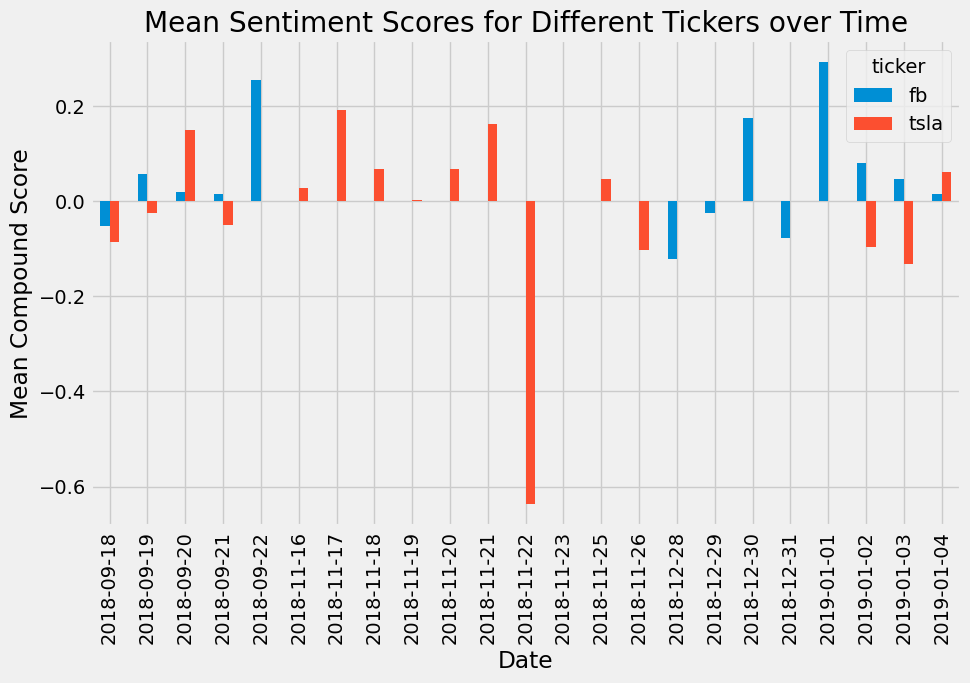

In [7]:
plt.style.use("fivethirtyeight")

# Grouping the scored_news DataFrame by date and ticker, and calculate the mean compound score
mean_scores = scored_news.groupby(['date', 'ticker']).mean()

# Unstacking the 'ticker' column for better visualization
mean_scores = mean_scores.unstack('ticker')

# Extracting the 'compound' score column
mean_compound_scores = mean_scores['compound']

mean_compound_scores.plot.bar(figsize=(10, 6))

plt.xlabel('Date')
plt.ylabel('Mean Compound Score')
plt.title('Mean Sentiment Scores for Different Tickers over Time')

plt.show()

### Addressing Weekends and Duplicate Entries

What transpired with Tesla on November 22nd? As we have the headlines organized in our DataFrame, an examination reveals a few issues on that specific day:

- There are only 5 headlines available for that date.
- Two of these headlines are identical to others but originate from different news sources.

This addresses the need for some data cleansing. While some headlines might be reporting the same news piece from various sources, the variations in wording can offer diverse perspectives on the same story. Additionally, when a particular news item is particularly significant, it tends to receive coverage from multiple sources. What we aim to eliminate are the completely identical headlines, as they are likely originating from the same journalist and essentially being "reposted" across different outlets.

In [8]:
# Counting the number of headlines in scored_news (store as integer)
num_news_before = scored_news['headline'].count()

# Dropping duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['headline', 'ticker'])

# Counting number of headlines after dropping duplicates
num_news_after = scored_news_clean['headline'].count()

print(
    f"Before, we had {num_news_before} headlines. After removing duplicates, we have {num_news_after} unique headlines.")

Before, we had 500 headlines. After removing duplicates, we have 476 unique headlines.


### Analyzing Sentiment for a Single Stock on a Single Trading Day

To gain a more thorough understanding of the data, we narrow our focus to a specific trading day and a single stock. Our goal is to create an informative plot that provides the finest level of detail: individual headlines and their associated sub-scores.

In [9]:
# Set the index to 'ticker' and 'date' columns in the cleaned DataFrame
single_day = scored_news_clean.set_index(['ticker', 'date'])

# Extract rows where 'ticker' is 'fb'
single_day = single_day.loc['fb']

# Reset the index to perform further operations
single_day.reset_index(inplace=True)

# Converting the 'date' column to string and filtering for entries on '2019-01-03'
single_day['date'] = pd.to_datetime(single_day['date'])
single_day = single_day[single_day['date'].dt.date == pd.Timestamp('2019-01-03').date()]

# Converting the 'time' column to datetime and extracting only the time part
single_day['time'] = pd.to_datetime(single_day['time']).dt.time

# Set the index to 'time' column
single_day.set_index('time', inplace=True)

# Sort the DataFrame based on the index (time)
single_day.sort_index(ascending=True, inplace=True)

# Ensuring 'ndate' column exists before dropping it
if 'ndate' in single_day.columns:
    # Drop the 'ndate' column
    single_day.drop('ndate', inplace=True, axis=1)

# Ensuring the 'date' column exists before dropping it
if 'date' in single_day.columns:
    # Dropping 'date' column
    single_day.drop('date', inplace=True, axis=1)

### Visualizing a Singular Trading Day

Our objective is to generate a plot that illustrates the positive, negative, and neutral scores for a particular day of trading and a specific stock. This represents just one of the numerous techniques for visualizing this dataset.

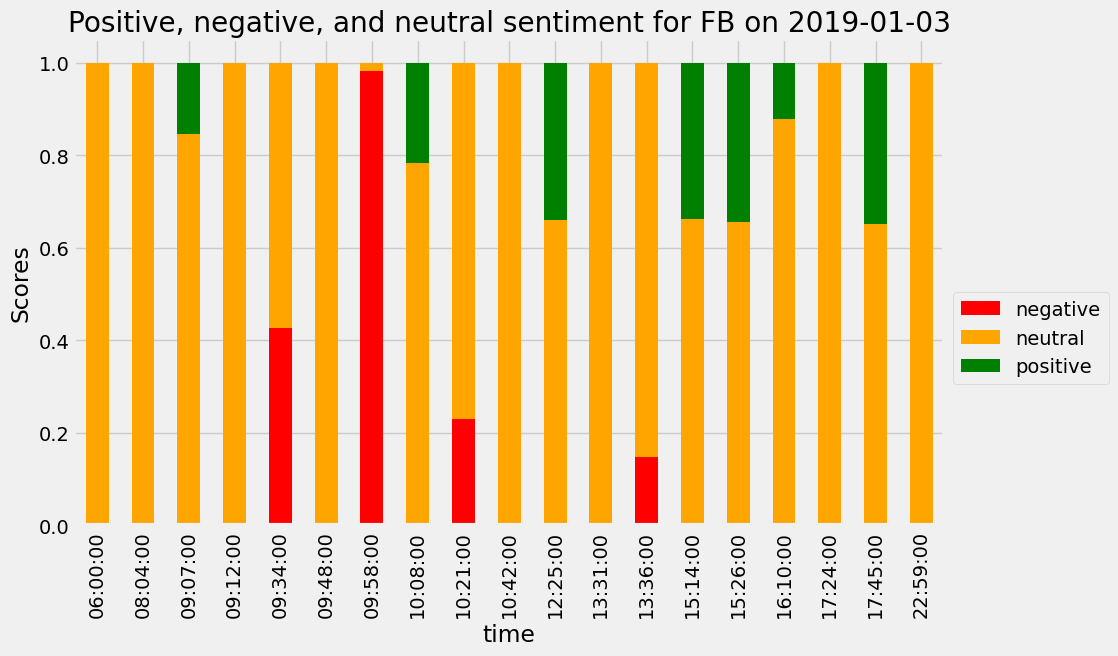

In [10]:
# Constants for the plot title and colors
TITLE = "Positive, negative, and neutral sentiment for FB on 2019-01-03"
COLORS = ["red", "orange", "green"]

# Dropping the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)

plot_day.columns = ['negative', 'neutral', 'positive']

plot_day.plot.bar(stacked=True,
                  figsize=(10, 6),
                  title=TITLE,
                  color=COLORS).legend(bbox_to_anchor=(1.2, 0.5))

plt.ylabel("Scores")

plt.show()

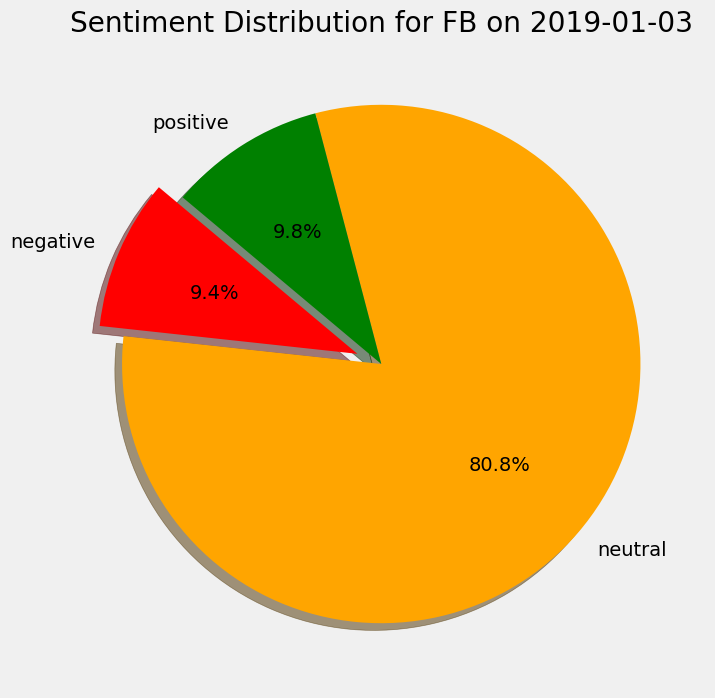

In [11]:
# Calculating the total count of each sentiment category
sentiment_counts = plot_day.sum()

labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['red', 'orange', 'green']
explode = (0.1, 0, 0)  # explode the 1st slice (i.e., 'negative')

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Sentiment Distribution for FB on 2019-01-03")
plt.show()